<a href="https://colab.research.google.com/github/hderoche/RNN_Bitcoin_Prediction/blob/master/StatistiquesDescriptivesBTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistiques descriptives sur l'historique du Bitcoin**

---
> 1.   Mesure de volatilité
> 2.   Corrélation volatilité / volume échangé
> 3.   Pourcentage par unité de temps
> 4.   Moyennes mobiles (exponentielles)
> 5.   Variances et écart-types
> 6.   Statistiques par année




---

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json
plt.style.use('fivethirtyeight')

### Importer les données

In [160]:
# dataBtc = pd.read_csv('data_btc.csv', header=0)
# dataBTC = pd.read_csv('price_btc_1h.csv', header=0, sep=',')
#dataBitstamp = pd.read_csv('Bitstamp_BTCUSD_1h.csv', header=0, sep=';')
dataBitstamp = pd.read_csv('Bitstamp_BTCUSD_d.csv', header=0, sep=';')
# This dataset has a column of Timstamp
print('Nom des colonnes :',dataBitstamp.columns)

### Drop du timestamp
#dataBitstamp = dataBitstamp.drop(['Unix Timestamp'], axis=1)
dataBitstamp = dataBitstamp.drop(['date','symbol'], axis=1)


# Data processing and slicing dataframe in order to have the right dimension to input in the RNN
data = pd.DataFrame(dataBitstamp, index=[i for i in range(dataBitstamp.shape[0])])
# The datafiles I had were reversed, meaning that the index of the lastest data was 0, so I had to reverse the dataframe
data = data[::-1]
#data = data.drop(['Date','Symbol', 'Volume USD'], axis=1)
print(data.shape)
print(data.head())


Nom des colonnes : Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD'],
      dtype='object')
(2221, 7)
            unix    open    high     low   close  Volume BTC  Volume USD
2220  1417132800  363.59  381.34  360.57  376.28  3220878.18     8617.15
2219  1417219200  376.42  386.60  372.25  376.72  2746157.05     7245.19
2218  1417305600  376.57  381.99  373.32  373.34  1145566.61     3046.33
2217  1417392000  376.40  382.31  373.03  378.39  2520662.37     6660.56
2216  1417478400  378.39  382.86  375.23  379.25  2593576.46     6832.53


### Indicateurs

In [161]:
def moving_average(data, param):
  data['MA' + str(param)] = data.iloc[:,3].rolling(window=param).mean()
  data = data[::-1]
  return data

def exponential_moving_average(data, param):
  data['EMA' + str(param)] = data.iloc[:, 3].ewm(span=param).mean()
  data = data[::-1]
  return data

print(moving_average(data, 200))
print(exponential_moving_average(data, 13)['EMA13'])

            unix      open      high  ...    Volume BTC    Volume USD        MA200
0     1608940800  24714.01  24768.79  ...  6.601946e+01  1.625054e+06  12564.92880
1     1608854400  23747.22  24777.00  ...  6.469229e+03  1.598233e+08  12490.10145
2     1608768000  23215.00  23779.14  ...  7.185482e+03  1.704848e+08  12421.30735
3     1608681600  23819.08  24096.90  ...  1.154197e+04  2.683244e+08  12354.58685
4     1608595200  22750.07  23843.21  ...  9.367609e+03  2.232779e+08  12289.09105
...          ...       ...       ...  ...           ...           ...          ...
2216  1417478400    378.39    382.86  ...  2.593576e+06  6.832530e+03          NaN
2217  1417392000    376.40    382.31  ...  2.520662e+06  6.660560e+03          NaN
2218  1417305600    376.57    381.99  ...  1.145567e+06  3.046330e+03          NaN
2219  1417219200    376.42    386.60  ...  2.746157e+06  7.245190e+03          NaN
2220  1417132800    363.59    381.34  ...  3.220878e+06  8.617150e+03          NaN

[22

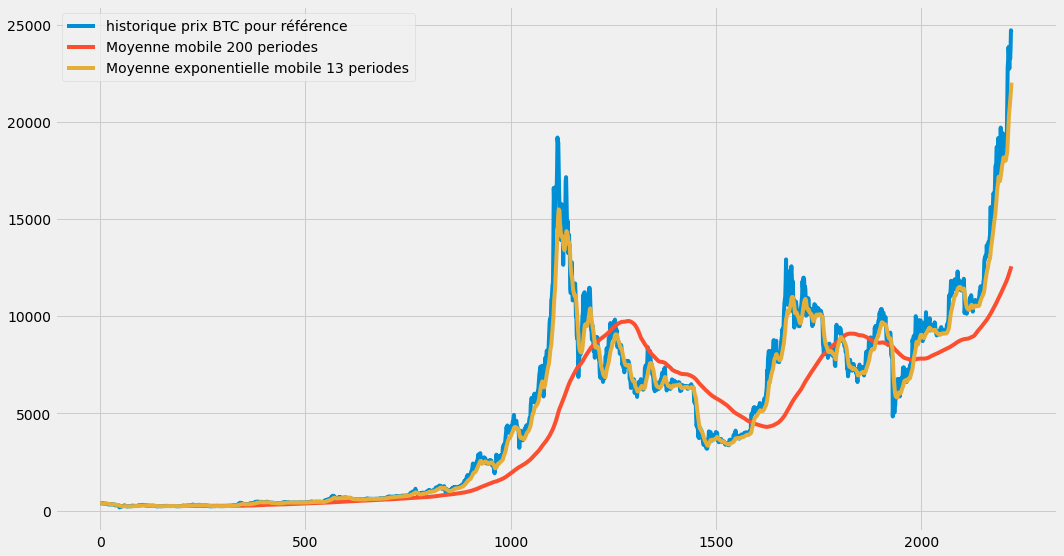

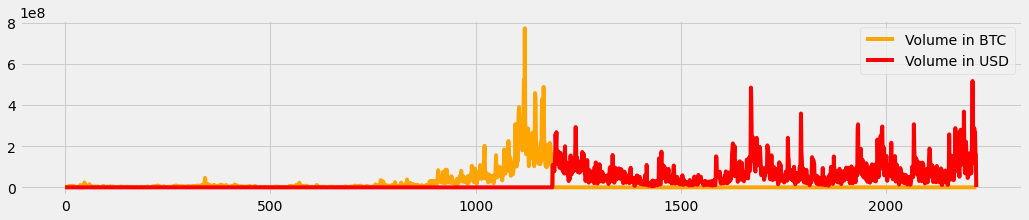

In [162]:
plt.figure(figsize=[16,9])
dataTemp = data.reset_index()
plt.plot(dataTemp['close'], label='historique prix BTC pour référence')
plt.plot(dataTemp['MA200'], label="Moyenne mobile 200 periodes")
plt.plot(dataTemp['EMA13'], label='Moyenne exponentielle mobile 13 periodes')
plt.legend()
plt.figure(figsize=[16,3])
plt.plot(dataTemp['Volume BTC'], color="orange", scaley='log', label="Volume in BTC")
plt.plot(dataTemp['Volume USD'], color="red", scaley='log', label="Volume in USD")
plt.legend()
plt.show()

Sur ces graphiques on peut voir que les moyennes mobiles permettent éventuellement d'avoir de l'information sur un changement de tendance.

Si la moyenne mobile se trouve au dessus du cours alors la tendance est à la vente

Dans le cas contraire, la tendance est à l'achat.

En se basant sur ces informations on peut par exemple scorer avec des règles préécrites pour que le robot puisse soit acheter soit vendre si un nombre suffisant de règles sont validées

### Volatilité et Volume (Correlation)

In [163]:
def volatility_max():
  data['vol'] = data['high'].sub(data['low'], axis=0)
  print(data.head())
volatility_max()

            unix    open    high     low  ...  Volume USD  MA200       EMA13    vol
2220  1417132800  363.59  381.34  360.57  ...     8617.15    NaN  360.570000  20.77
2219  1417219200  376.42  386.60  372.25  ...     7245.19    NaN  366.859231  14.35
2218  1417305600  376.57  381.99  373.32  ...     3046.33    NaN  369.351969   8.67
2217  1417392000  376.40  382.31  373.03  ...     6660.56    NaN  370.493656   9.28
2216  1417478400  378.39  382.86  375.23  ...     6832.53    NaN  371.752870   7.63

[5 rows x 10 columns]


On calcule la volatilité comme la différence entre le point le plus haut et le point le plus bas de la même période

Ensuite, je normalise les valeurs pour permettre de rendre les calculs plus rapides.

In [164]:
# Pre-processing for display
def normalize(df):
    result = df.copy()
    result = result.drop(['unix'], axis=1)
    for feature_name in result.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

dataN = normalize(data)
dfCorrelationN = pd.DataFrame()
dfCorrelationN['volumeBTC'] = dataN['Volume BTC']
dfCorrelationN['volatility'] = dataN['vol']
print(dfCorrelationN.head())
print(dfCorrelationN.corr())

      volumeBTC  volatility
2220   0.004170    0.004480
2219   0.003556    0.003096
2218   0.001483    0.001870
2217   0.003264    0.002002
2216   0.003358    0.001646
            volumeBTC  volatility
volumeBTC    1.000000    0.612587
volatility   0.612587    1.000000


On obtient une corrélation entre la volatilité et le volume de **0.61** soit **61%**

Cela veut dire que lorsque la volatilité augmente, dans 61% du temps cela résulte d'un plus grand volume.

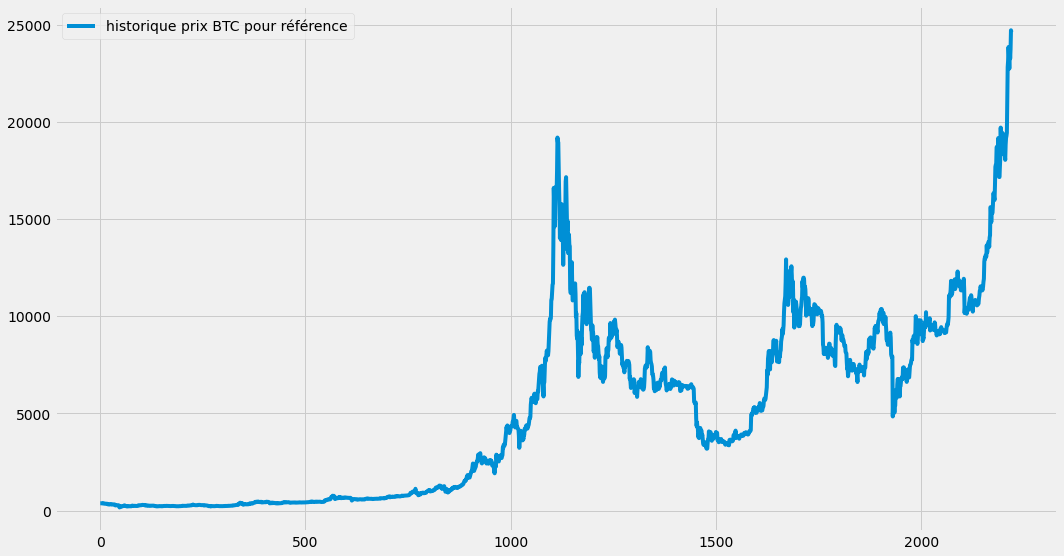

In [165]:
plt.figure(figsize=[16,9])
dataTemp = data.reset_index()
plt.plot(dataTemp['close'], label='historique prix BTC pour référence')
plt.legend()


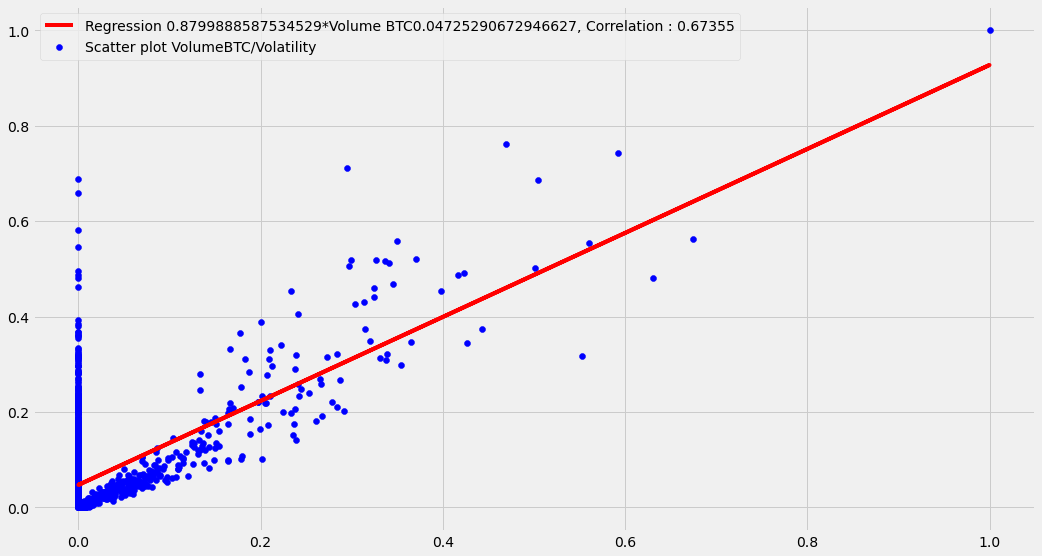

In [166]:
plt.figure(figsize=[16,9])
plt.scatter(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], color='blue', 
         label='Scatter plot VolumeBTC/Volatility')

# Droite de régression
m, b = np.polyfit(dfCorrelationN['volumeBTC'], dfCorrelationN['volatility'], 1)

plt.plot(dfCorrelationN['volumeBTC'], m*dfCorrelationN['volumeBTC'] + b, color='red', 
         label='Regression ' + str(m) + '*Volume BTC'+ str(b) + ', Correlation : 0.67355')
plt.legend()
plt.show()

Il y a bien une relation entre le volume et la volatilité

          open      high       low  ...  MA200     EMA13       vol
2220  0.008211  0.006860  0.008539  ...    NaN  0.006579  0.004480
2219  0.008733  0.007074  0.009018  ...    NaN  0.006867  0.003096
2218  0.008739  0.006886  0.009062  ...    NaN  0.006982  0.001870
2217  0.008732  0.006899  0.009050  ...    NaN  0.007034  0.002002
2216  0.008814  0.006921  0.009140  ...    NaN  0.007092  0.001646

[5 rows x 9 columns]
   index      open      high  ...     MA200     EMA13       vol
0      0  1.000000  0.999666  ...  1.000000  1.000000  0.051019
1      1  0.960623  1.000000  ...  0.993929  0.980735  0.296220
2      2  0.938946  0.959377  ...  0.988347  0.966888  0.232768
3      3  0.963550  0.972313  ...  0.982933  0.956114  0.317533
4      4  0.920009  0.961986  ...  0.977619  0.944119  0.314866

[5 rows x 10 columns]


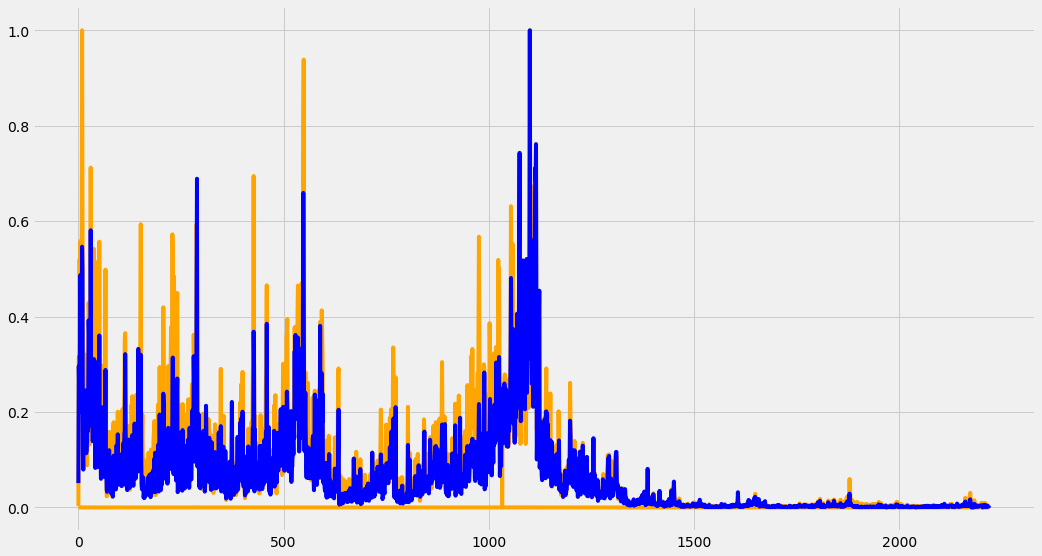

In [167]:
# removing noisy data

print(dataN.head())
dataN = dataN[::-1].reset_index()
print(dataN.head())
plt.figure(figsize=[16,9])
plt.plot(dataN['Volume BTC'], color='orange')
plt.plot(dataN['Volume USD'], color='orange')
plt.plot(dataN['vol'], color='blue')
plt.plot()
plt.show()

### Moyenne des pourcentages volatilité

In [168]:
data['diff'] = data['close'] - data['open']
print(data.head())
data['per'] = ( data['diff']*100 )/data['open']

meanVolatilityPercentage = data['per'].mean()
minVolatilityPercentage = data['per'].min()
maxVolatilityPercentage = data['per'].max()
print('mean',meanVolatilityPercentage)
print('max',maxVolatilityPercentage)
print('min',minVolatilityPercentage)

            unix    open    high     low  ...  MA200       EMA13    vol   diff
2220  1417132800  363.59  381.34  360.57  ...    NaN  360.570000  20.77  12.69
2219  1417219200  376.42  386.60  372.25  ...    NaN  366.859231  14.35   0.30
2218  1417305600  376.57  381.99  373.32  ...    NaN  369.351969   8.67  -3.23
2217  1417392000  376.40  382.31  373.03  ...    NaN  370.493656   9.28   1.99
2216  1417478400  378.39  382.86  375.23  ...    NaN  371.752870   7.63   0.86

[5 rows x 11 columns]
mean 0.26124685072043163
max 28.895061728395063
min -39.14663744031452


*   La moyenne de volatilité est de **0.26%**
*   Le max de volatilité est de **28.9%**
*   Le min de volatilité est de **-39.1%**




### Jour Up Down Neutre



In [169]:
def count_up_down_period(data):
  up_days = 0
  down_days = 0
  neutral_days = 0
  for i in range(data.shape[0]):
    if data['diff'][i] > 0:
      up_days+=1
    elif data['diff'][i] < 0:
      down_days+=1
    elif data['diff'][i] == 0:
      neutral_days+=1
  return up_days, down_days, neutral_days

In [170]:
up, down, neutral = count_up_down_period(data)
print('number of up days : ',up)
print('number of down days : ',down)
print('number of neutral days : ',neutral)

number of up days :  1198
number of down days :  1012
number of neutral days :  11


### Statistiques par année

In [222]:
def stats(data):
  mean.append(data['close'].mean())
  max.append(data['close'].max())
  min.append(data['close'].min())
  data['diff'] = data['close'] - data['open']
  data['per'] = ( data['diff']*100 )/data['open']
  vol.append(data['per'].mean())
  volumeBTC.append(data['Volume BTC'].mean())
  volumeUSD.append(data['Volume USD'].mean())

In [225]:
year_data = data.copy()
year_data['date'] = pd.to_datetime(year_data['unix'], unit='s')
year_data['year'] = year_data['date'].dt.year

unique_year = year_data['year'].drop_duplicates()
year_data = year_data.drop(['unix', 'date'], axis=1)

max = []
min = []
mean = []
vol = []
volumeUSD = []
volumeBTC = []
years = ['all history']

stats(year_data)
# Iteration sur chaque année
for year in unique_year:
  # selection des données
  mask = year_data['year'] == year
  strY = str(year)
  temp_data = year_data.loc[mask]
  temp_data = temp_data.reset_index()
  years.append(year)

  ## Stats
  stats(temp_data)


# Ajout des données dans le dataframe Pandas
df_year = pd.DataFrame(years)
df_year = df_year.set_index([0])
df_year['min'] = min
df_year['moyenne'] = mean
df_year['max'] = max
df_year['vol moyenne'] = vol
df_year['Volume BTC'] = volumeBTC
df_year['Volume USD'] = volumeUSD


print(df_year.to_string())

                 min       moyenne       max  vol moyenne    Volume BTC    Volume USD
0                                                                                    
all history   162.00   5011.061396  24705.15     0.261247  1.587456e+07  3.369355e+07
2014          311.94    344.781176    379.25    -0.381627  2.844332e+06  8.341504e+03
2015          162.00    272.140110    463.61     0.119211  4.032125e+06  1.436841e+04
2016          367.64    566.694317    975.97     0.250185  2.979942e+06  5.329448e+03
2017          788.81   3972.231096  19187.78     0.859005  5.930721e+07  1.281281e+04
2018         3179.54   7522.233863  17149.67    -0.258512  2.998677e+07  5.437589e+07
2019         3359.33   7363.344055  12920.54     0.241781  8.204384e+03  6.363052e+07
2020         4841.67  10880.895429  24705.15     0.417437  8.351459e+03  8.794705e+07


Statistiques par année du bitcoin

On remarque que les années de bull run (2017, fin 2020), la volatilité moyenne du bitcoin est plus haute que la moyenne

Et les années de Bear Market (2014,2018) ont des volatilités négatives